<a href="https://colab.research.google.com/github/BShria/Customer-Segmentation/blob/main/cust_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CUSTOMER SEGMENTATION**


---



In [2]:
# Importing the required Libraries
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
 
rcParams['figure.figsize'] = (8,6)

from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.express as px
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py

# Reading the dataset

---
This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Link: https://archive.ics.uci.edu/ml/datasets/online+retail

The dataset has 541909 rows. Each row represents the transaction that occurs. It includes the InvoiceNo, StockCode, Description of Product, Quantity, InvoiceDate, UnitPrice, CustomerID and Country.

In [3]:
# Importing the Online Retail dataset
df = pd.read_excel('https://github.com/BShria/Customer-Segmentation/blob/main/Online%20Retail.xlsx?raw=true')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


# Cleaning the Data

---












* Description of the dataframe




In [4]:
# Description of the dataframe
df.min()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Quantity                    -80995
InvoiceDate    2010-12-01 08:26:00
UnitPrice                -11062.06
CustomerID                 12346.0
Country                  Australia
dtype: object

In [5]:
# Checking the number of missing values corresponding to each column
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# Removing rows with missing values
df = df.dropna()

# Dropping columns InvoiceNo, StockCode, Description, Country as they is redundant
df = df.drop(['InvoiceNo','StockCode','Description' ,'Country'], axis=1)

# Removing rows with Quantity <= 0
negative_quantity = df[df['Quantity']<=0].index
df.drop(negative_quantity, inplace=True, axis=0)

# Removing rows with UnitPrice <= 0
negative_price = df[df['UnitPrice']<=0].index
df.drop(negative_price, inplace=True, axis=0)

# Converting CustomerID values form float type to int
df.CustomerID = df.CustomerID.astype(int)
df.head(5)

,Quantity,InvoiceDate,UnitPrice,CustomerID
0,6,2010-12-01 08:26:00,2.55,17850
1,6,2010-12-01 08:26:00,3.39,17850
2,8,2010-12-01 08:26:00,2.75,17850
3,6,2010-12-01 08:26:00,3.39,17850
4,6,2010-12-01 08:26:00,3.39,17850


# Sampling the Dataset

---



In [7]:
# Sampling the dataset 
sample = df.sample(10000, random_state = 42)
index = pd.Series(list(range(0,10000)))
sample.set_index(index, drop=False, inplace=True);

# Calculating Total Price against each purchase
sample["TotalPrice"] = sample["Quantity"] * sample["UnitPrice"]

# Extracting the dates from Invoice Date which is in datetime format
from datetime import datetime
sample["InvoiceDate"] = sample["InvoiceDate"].dt.date
sample.head(5)

,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
0,6,2011-11-11,2.08,15034,12.48
1,12,2011-07-13,2.95,12528,35.40
2,16,2011-10-04,0.83,15111,13.28
3,2,2011-07-14,8.50,14156,17.00
4,200,2011-03-30,1.65,13802,330.00


#Creating a Recency Frequency Monetary Value (RFM) Model


---


Recency, frequency, monetary value (RFM) model is one of the most extensively used approaches in customer segmentation. The primary aim of RFM analysis is to identify a company's or an organization's best customers based on certain attributes. 
The RFM model is based on three quantitative factors:





*   Recency - How recently the customers have made the purchase.


*   Frequency - How often customers have made the purchase. 


*   Monetary Value - How much the customers have spent.


In [8]:
# Creating the RFM Model
max_date=max(sample.InvoiceDate)
rfm=sample.groupby('CustomerID').agg({'InvoiceDate': lambda date:(max_date - date.max()).days + 1,
                                     'CustomerID': lambda cust: len(cust),
                                      'TotalPrice': lambda price: price.sum()})
rfm.columns=['Recency','Frequency','Monetary']
rfm.head(5)

,Recency,Frequency,Monetary
CustomerID,,,
12347,40,7,129.70
12348,319,2,83.52
12349,19,1,12.50
12350,311,2,65.20
12352,37,4,421.65


# **K-Means Algorithm**

---


K-means clustering algorithm makes certain assumptions about the nature of the input data. The assumptions are as follows:
*   Each variable in the data is symmetric
*   The variance of the distribution of each attribute (variable) is spherical

*   All variables have the same variance
*   Each cluster has roughly equal number of observations


#Analysis of the data extracted after RFM Modelling

---



In [9]:
# Description of the rfm dataframe
rfm.describe()

,Recency,Frequency,Monetary
count,2665.000000,2665.000000,2665.000000
mean,110.759099,3.752345,80.553415
std,103.231171,6.970782,274.700673
min,1.000000,1.000000,0.390000
25%,26.000000,1.000000,15.000000
50%,72.000000,2.000000,30.000000
75%,181.000000,4.000000,71.080000
max,374.000000,171.000000,7476.120000


Text(0.5, 1.0, 'Fig.5.1: Range of the RFM features')

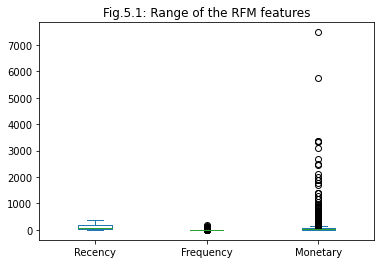

In [10]:
# Box Plot to analyse the distribution of data
fig = rfm.plot.box()
fig.set_title('Fig.5.1: Range of the RFM features')

In [11]:
rfm['Recency'].skew()

0.9419160349502619

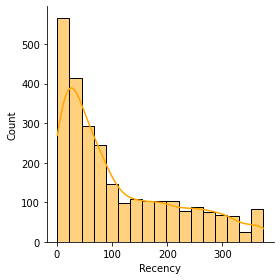

In [12]:
sns.displot(rfm.Recency, kde=True, color='orange', height=4, aspect=1)

In [13]:
rfm['Frequency'].skew()

13.18802368680814

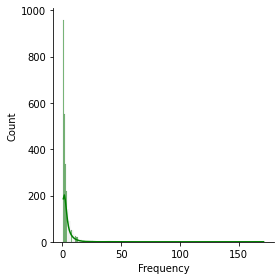

In [14]:
sns.displot(rfm.Frequency, kde=True, color='Green', height=4, aspect=1)

In [15]:
rfm['Monetary'].skew()

14.910987361225443

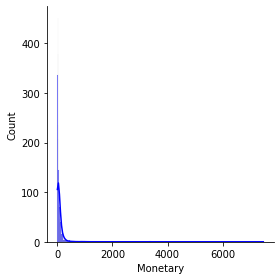

In [16]:
sns.displot(rfm.Monetary, kde=True, color='Blue', height=4, aspect=1)

# Transforming Data


---
To manage the skewness of data and to make the probability distribution of data symmetric. 


---


*   ***Log Transformation***



---








In [17]:
## Log Transformation
# Recency
recency_log = np.log(rfm['Recency'])
recency_log.skew()

-0.7198816256981649

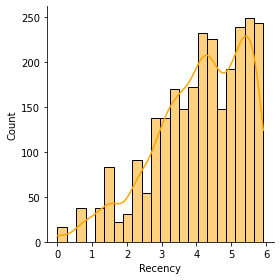

In [18]:
sns.displot(recency_log, kde=True, color='orange', height=4, aspect=1)

In [19]:
# Frequency
frequency_log = np.log(rfm['Frequency'])
frequency_log.skew()

0.8218818004304456

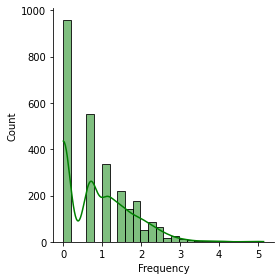

In [20]:
sns.displot(frequency_log, kde=True, color='green', height=4, aspect=1)

In [21]:
# Monetary
monetary_log = np.log(rfm['Monetary'])
monetary_log.skew()

0.10209844098355485

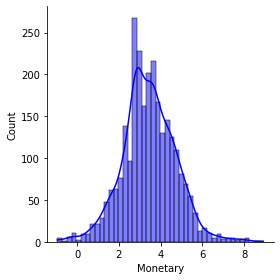

In [22]:
sns.displot(monetary_log, kde=True, color='blue', height=4, aspect=1)



---



*  ***Square Root Transformation***



---



In [23]:
## Square Root Transformation
# Recency
recency_sqrt = np.sqrt(rfm['Recency'])
recency_sqrt.skew()

0.3327355555263751

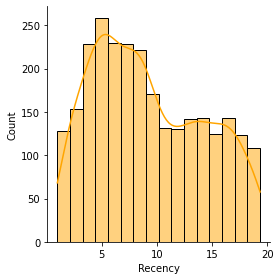

In [24]:
sns.displot(recency_sqrt, kde=True, color='orange', height=4, aspect=1)

In [25]:
# Frequency
frequency_sqrt = np.sqrt(rfm['Frequency'])
frequency_sqrt.skew()

3.519791158958472

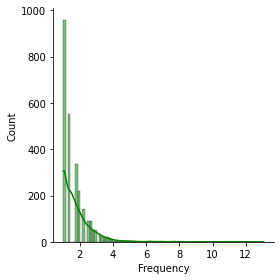

In [26]:
sns.displot(frequency_sqrt, kde=True, color='green', height=4, aspect=1)

In [27]:
# Monetary
monetary_sqrt = np.sqrt(rfm['Monetary'])
monetary_sqrt.skew()

4.712375019810757

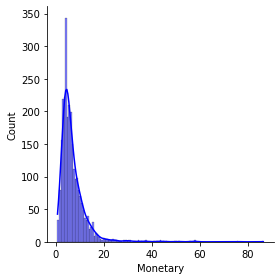

In [28]:
sns.displot(monetary_sqrt, kde=True, color='blue', height=4, aspect=1)



---



*   ***Box-Cox Transformation***



---

> Gives the best result hence choosing this 







In [29]:
## Box-Cox Transformation

# Recency
recency_bcox = pd.Series(stats.boxcox(rfm['Recency'])[0])
recency_bcox = recency_bcox.rename('Recency')
recency_bcox.skew()

-0.10304787698346707

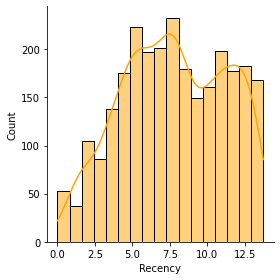

In [30]:
sns.displot(recency_bcox, kde=True, color='orange', height=4, aspect=1)

In [31]:
# Frequency
frequency_bcox = pd.Series(stats.boxcox(rfm['Frequency'])[0])
frequency_bcox = frequency_bcox.rename('Frequency')
frequency_bcox.skew()

0.1513177739575201

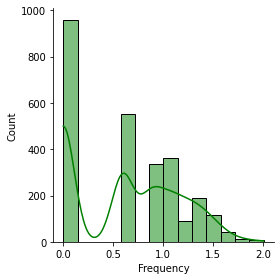

In [32]:
sns.displot(frequency_bcox, kde=True, color='green', height=4, aspect=1)

In [33]:
# Monetary
monetary_bcox = pd.Series(stats.boxcox(rfm['Monetary'])[0])
monetary_bcox = monetary_bcox.rename('Monetary')
monetary_bcox.skew()

-0.007362053674569914

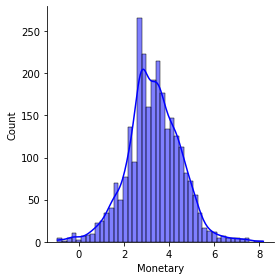

In [34]:
sns.displot(monetary_bcox, kde=True, color='blue', height=4, aspect=1)

Text(0.5, 1.0, 'Fig.5.2: RFM features after Box-Cox Transformation')

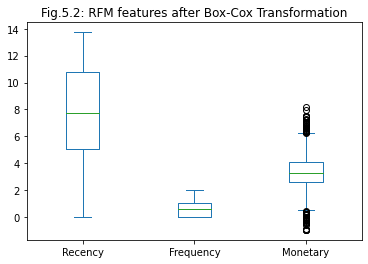

In [35]:
# Creating a new Dataframe transformed_rfm which contains the Box-Cox Transformed Data
frame={'Recency':pd.Series(recency_bcox),'Frequency':pd.Series(frequency_bcox),'Monetary':(pd.Series(monetary_bcox))}
transformed_rfm=pd.DataFrame(frame)

# Box plot of transformed_rfm
fig = transformed_rfm.plot.box()
fig.set_title('Fig.5.2: RFM features after Box-Cox Transformation')

# Feature Scaling

---
Machine learning models often become biased towards feature having greater magnitude & variance. Hence Data preprocessing is required.

Most common feature scaling techniques:


---


*   Normalisation using MinMaxScaler from sklearn.preprocessing package.


---






Text(0.5, 1.0, 'Fig.5.3: RFM features after Normalisation')

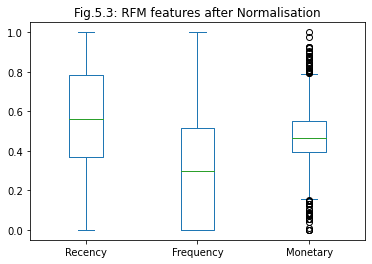

In [36]:
# Normalisation using MinMaxScaler from sklearn.preprocessing package
from sklearn.preprocessing import MinMaxScaler

normalised_rfm = MinMaxScaler().fit_transform(transformed_rfm)
normalised_rfm = pd.DataFrame(normalised_rfm, columns=transformed_rfm.columns)
fig = normalised_rfm.plot.box()
fig.set_title('Fig.5.3: RFM features after Normalisation')



---


*   Standardization using StandardScaler from sklearn.preprocessing package.


---







Text(0.5, 1.0, 'Fig.5.4: RFM features after Standardisation')

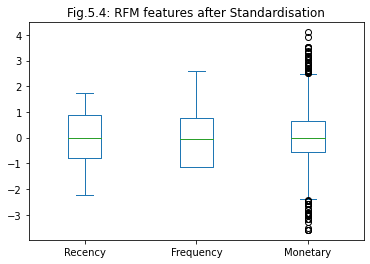

In [37]:
#Standardization using StandardScaler from sklearn.preprocessing 
from sklearn.preprocessing import StandardScaler
  
standardized_rfm = StandardScaler().fit_transform(transformed_rfm)
standardized_rfm = pd.DataFrame(standardized_rfm, columns=transformed_rfm.columns)
fig = standardized_rfm.plot.box()
fig.set_title('Fig.5.4: RFM features after Standardisation')

Here form the boxplots we can infer that standardization has performed better than normalisation in terms of scaling the transformed data. Hence the standardized data is considered for furthur analysis. 

# 3-D Visualization of The RFM data


---



In [38]:
from mpl_toolkits import mplot3d

rcParams['figure.figsize'] = (8,6)

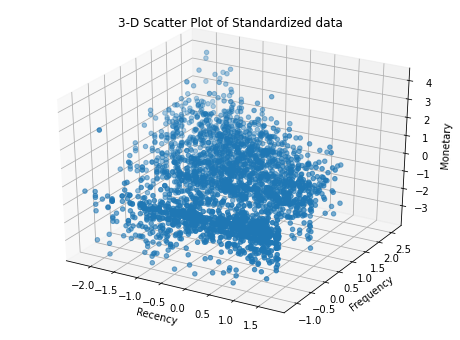

In [39]:
x = standardized_rfm['Recency']
y = standardized_rfm['Frequency']
z = standardized_rfm['Monetary']
ax = plt.axes(projection='3d')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');
ax.set_title('3-D Scatter Plot of Standardized data')
ax.scatter(x,y,z)

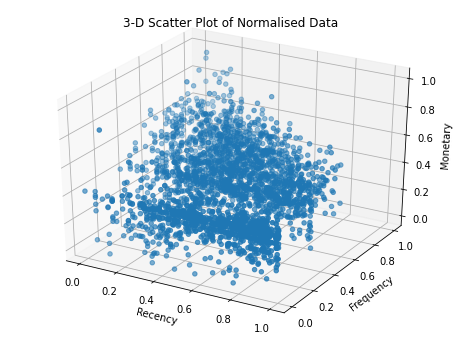

In [40]:
x = normalised_rfm['Recency']
y = normalised_rfm['Frequency']
z = normalised_rfm['Monetary']
ax = plt.axes(projection='3d')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');
ax.set_title('3-D Scatter Plot of Normalised Data')
ax.scatter(x,y,z)

# Clustering of Data using K-means Algorithm


---



*   Elbow Method



---



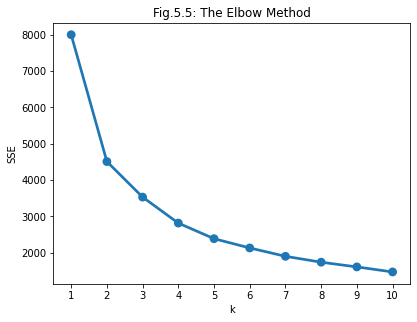

In [41]:
rcParams['figure.figsize'] = (6.4,4.8)

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(standardized_rfm)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('Fig.5.5: The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()



---



*   Clustering the standardized_rfm considering K = 3, 4, 5.



---

***K = 3***


---



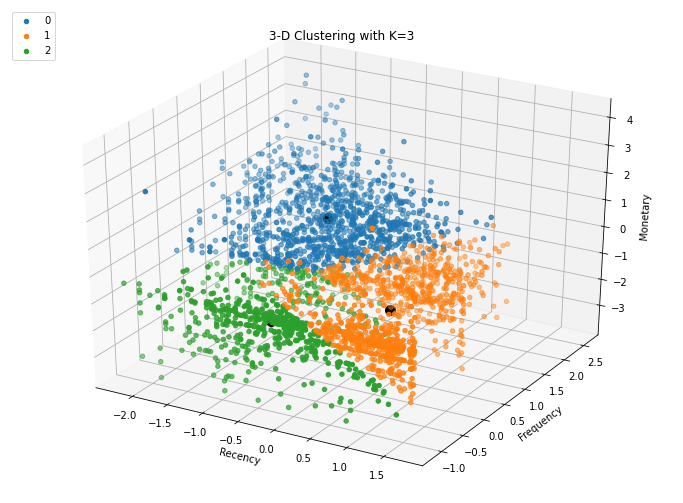

In [42]:
rcParams['figure.figsize'] = (12,9)
k = 3
rfm3 = standardized_rfm.copy()
kmeans3 = KMeans(n_clusters=k, random_state=42)
kmeans3.fit(rfm3)
labels = kmeans3.predict(rfm3)


# Scatter Plot
ax = plt.axes(projection='3d')
for i in range(0,k):
  labeled_rfm = rfm3[labels == i]
  x = labeled_rfm['Recency']
  y = labeled_rfm['Frequency']
  z = labeled_rfm['Monetary']
  ax.scatter(x, y, z, label = i)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');
ax.legend(loc = 'upper left')
ax.set_title('3-D Clustering with K=3')
# Plotting the centroids
centroids3 = kmeans3.cluster_centers_
ax.scatter(centroids3[:,0], centroids3[:,1], centroids3[:,2], c='black', s=100, depthshade=False)

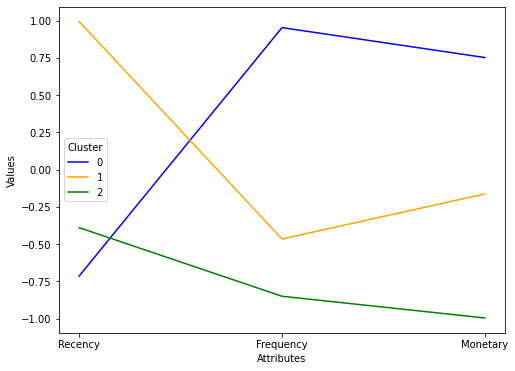

In [43]:
# Using a Snake Plot for differentiating between the clusters
rfm3['Cluster'] = labels
clusters3 = rfm3.groupby('Cluster').agg(['mean'])
clusters3['Cluster'] = clusters3.index
clusters3 = clusters3.melt(id_vars='Cluster', var_name = 'Attributes',
              value_name = 'Values')

rcParams['figure.figsize']=(8,6)
sns.lineplot(x='Attributes', y='Values', hue='Cluster', data=clusters3, palette= ['blue','orange','green'])



---


***K = 4***


---



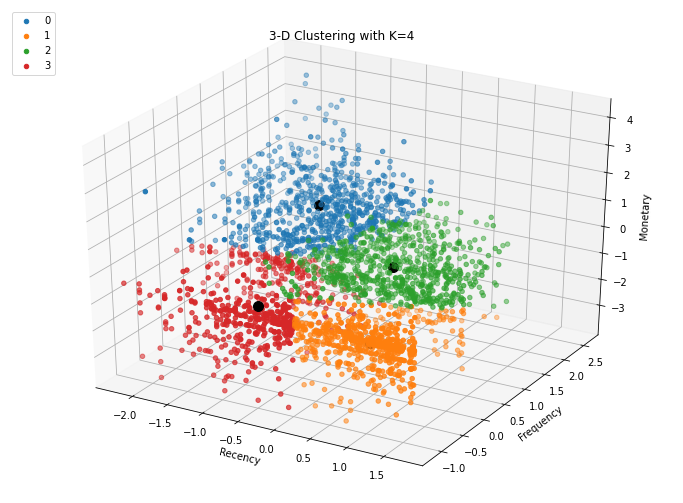

In [44]:
rcParams['figure.figsize'] = (12,9)
k = 4
rfm4 = standardized_rfm.copy();
kmeans4 = KMeans(n_clusters=k, random_state=42)
kmeans4.fit(rfm4)
labels = kmeans4.predict(rfm4)

# Scatter Plot 
ax = plt.axes(projection='3d')
for i in range(0,k):
  labeled_rfm = rfm4[labels == i]
  x = labeled_rfm['Recency']
  y = labeled_rfm['Frequency']
  z = labeled_rfm['Monetary']
  ax.scatter(x, y, z, label = i)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');
ax.legend(loc = 'upper left')
ax.set_title('3-D Clustering with K=4')

# Plotting the Centroids
centroids4 = kmeans4.cluster_centers_
ax.scatter(centroids4[:,0], centroids4[:,1], centroids4[:,2], c='black', s=100, depthshade=False)

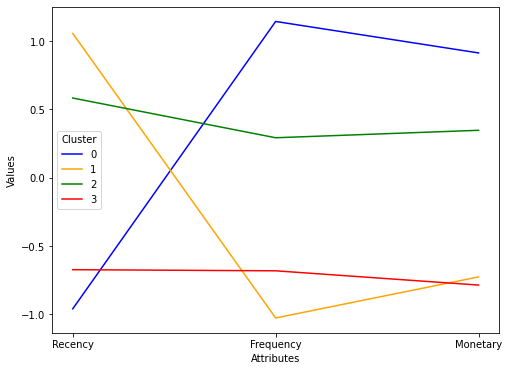

In [45]:
# Using a Snake Plot for differentiating between the clusters
rfm4['Cluster'] = labels
clusters4 = rfm4.groupby('Cluster').agg(['mean'])
clusters4['Cluster'] = clusters4.index
clusters4 = clusters4.melt(id_vars='Cluster', var_name = 'Attributes',
              value_name = 'Values')

rcParams['figure.figsize']=(8,6)
sns.lineplot(x='Attributes', y='Values', hue='Cluster', data=clusters4, palette= ['blue','orange','green','red'])



---



***K = 5***

---



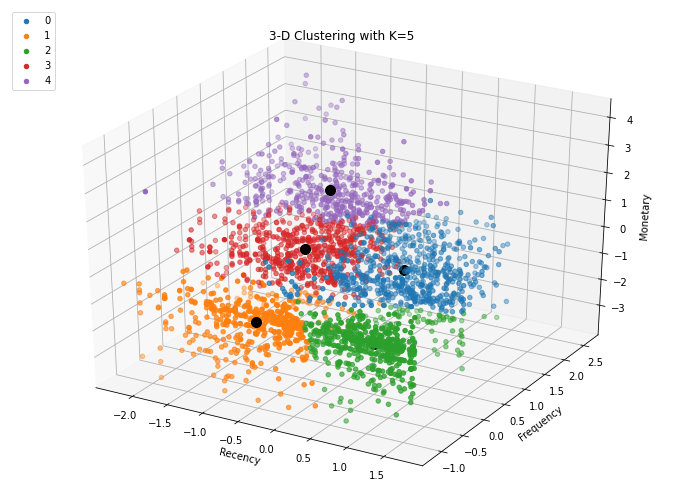

In [46]:
rcParams['figure.figsize'] = (12,9)
k = 5
rfm5 = standardized_rfm.copy();
kmeans5 = KMeans(n_clusters=k, random_state=42)
kmeans5.fit(rfm5)
labels = kmeans5.predict(rfm5)

# Scatter Plot 
ax = plt.axes(projection='3d')
for i in range(0,k):
  labeled_rfm = rfm5[labels == i]
  x = labeled_rfm['Recency']
  y = labeled_rfm['Frequency']
  z = labeled_rfm['Monetary']
  ax.scatter(x, y, z, label = i)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');
ax.legend(loc = 'upper left')
ax.set_title('3-D Clustering with K=5')

# Plotting the Centroids
centroids5 = kmeans5.cluster_centers_
ax.scatter(centroids5[:,0], centroids5[:,1], centroids5[:,2], c='black', s=100, depthshade=False)

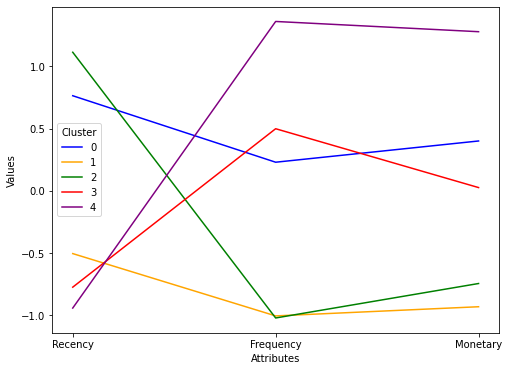

In [47]:
# Using a Snake Plot for differentiating between the clusters
rfm5['Cluster'] = labels
clusters5 = rfm5.groupby('Cluster').agg(['mean'])
clusters5['Cluster'] = clusters5.index
clusters5 = clusters5.melt(id_vars='Cluster', var_name = 'Attributes',
              value_name = 'Values')

rcParams['figure.figsize']=(8,6)
sns.lineplot(x='Attributes', y='Values', hue='Cluster', data=clusters5, palette= ['blue','orange','green','red','purple'])



# Results


---












In [52]:
# 3d scatterplot using plotly
import plotly.io as pio
import numpy as np

Scene = dict(xaxis = dict(title  = 'Monetary -->'),yaxis = dict(title  = 'Frequency --->'),zaxis = dict(title  = 'Recency-->'))


labels = kmeans4.labels_
datapoints = go.Scatter3d(x=rfm4['Monetary'], y=rfm['Frequency'], z=rfm4['Recency'], 
                          mode='markers', marker=dict(color = labels, colorscale='portland',
                                                      size= 5,opacity=0.0, line=dict(color='black',width = 2)))

clusters=go.Scatter3d(x=centroids4[:,2],y=centroids4[:,1],z=centroids4[:,0],
                    mode='markers',marker=dict(color='black',colorscale='portland',size=12))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 600,width = 800)
data = go.Data([datapoints,clusters])
fig = go.Figure(data = data, layout = layout)
fig.show()
fig.write_html("Myplot.html")
#pio.show(datapoints)

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:40: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




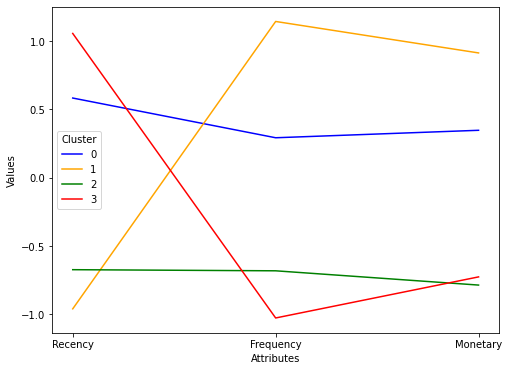

We can see that the optimal number of Clusters is 4. 

After analysing the clusters we infer that :



*   **Cluster - 0** were more frequent and they spent more but bought the products long ago. Therefore this could be the cluster of former but potential customers. The concerned company should try to re-engage these customers by target marketing and advertising as former buyers are usually better prospects than non buyers because they have already shown interest and ability to buy. 

*   **Cluster - 1**  bought the products recently and are the most frequent customers with the highest expenditure. Hence this could be the cluster of regular and loyal customers and therefore of highest priotity. Marketing policies should be devised for retaining this group of potential buyers because is it observed that increasing customer retention rates by 5% has increased the profit by 25% to 95% for an average business.

*   **Cluster - 2**  bought the products recently, but are less frequent with lesser expenditure. Therefore this could be the cluster of new customers. Coherent strategies should be developed for building their brand trust.

*   **Cluster - 3**  were least frequent with less expediture and bought the products long ago. Hence this could be the cluster of churned customers. This category of customers are the least profitable but can be extremely helpful for churn analysis. Churn rate is the rate at which customers stop engaging with a business over a specified amount of time and churn analysis is the process of understanding the reason behind it based on statistical data. Therefore analysing these fluctuating churn rates can provide insightful observations which may help to actively reduce churn rates and eventually resolve customer retention problems. 


In [53]:
clusters4_1 = rfm4.groupby('Cluster').agg(['mean'])
clusters4_1['Count'] = rfm4.groupby('Cluster').count().Recency
clusters4_1

,Recency,Frequency,Monetary,Count
,mean,mean,mean,
Cluster,,,,
0,-0.959329,1.143474,0.913213,719
1,1.055767,-1.026211,-0.725601,621
2,0.583150,0.292516,0.347159,737
3,-0.672883,-0.681063,-0.785473,588


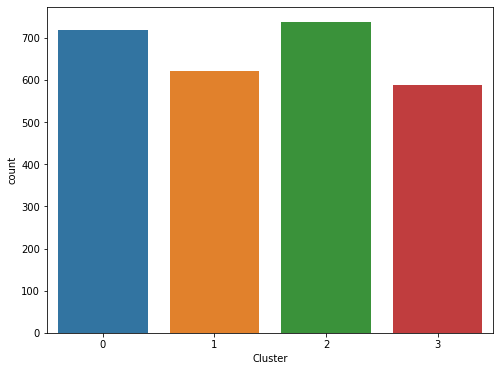

In [54]:
rcParams['figure.figsize']=(8,6)
sns.countplot(x=rfm4['Cluster'])